There are basically three types of recommender systems:-

Demographic Filtering- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Content Based Filtering- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

Collaborative Filtering- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.


In [1]:
import pandas as pd 
import numpy as np 
from collections import deque 
import plotly.graph_objs as go
import plotly.offline as py
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Data :

We'll load and take just a peak at our data.

In [2]:
# Load TMDB data
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
df1.columns = ['id','Name','cast','crew']
df2= df2.merge(df1,on='id')
df2['year'] = pd.to_datetime(df2['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
print(df1.shape)
print(df2.shape)
print(df2.sample(3))

(4803, 4)
(4803, 24)
        budget                                             genres  \
2732  13000000  [{"id": 18, "name": "Drama"}, {"id": 10751, "n...   
651   65000000  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   
2689  14000000                     [{"id": 35, "name": "Comedy"}]   

                                             homepage      id  \
2732                                              NaN    9816   
651                                               NaN  196867   
2689  http://www.foxsearchlight.com/ourfamilywedding/   34563   

                                               keywords original_language  \
2732  [{"id": 4118, "name": "ballet dancer"}, {"id":...                en   
651   [{"id": 4344, "name": "musical"}, {"id": 13014...                en   
2689  [{"id": 10188, "name": "interracial marriage"}...                en   

           original_title                                           overview  \
2732  Save the Last Dance  A white midwestern girl m

In [3]:
# Load Netflix data for movie titles :
movie_titles = pd.read_csv('../input/netflix-prize-data/movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
print(movie_titles.head(5))

Shape Movie-Titles:	(17770, 2)
      Year                          Name
Id                                      
1   2003.0               Dinosaur Planet
2   2004.0    Isle of Man TT 2004 Review
3   1997.0                     Character
4   1994.0  Paula Abdul's Get Up & Dance
5   2004.0      The Rise and Fall of ECW


In [4]:
# Load Netflix data for user data (movie ID is indexed):
df_raw1 = pd.read_csv('../input/netflix-prize-data/combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
#df_raw2 = pd.read_csv('../input/netflix-prize-data/combined_data_2.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
#df_raw3 = pd.read_csv('../input/netflix-prize-data/combined_data_3.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
#df_raw4 = pd.read_csv('../input/netflix-prize-data/combined_data_4.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])

df_raw = df_raw1
#df_raw = df_raw.append(df_raw2)
#df_raw = df_raw.append(df_raw3)
#df_raw = df_raw.append(df_raw4)

df_raw.index = np.arange(0,len(df_raw))
#print(df_raw.index)    #RangeIndex(start=0, stop=24058263, step=1)

df_raw['Rating'] = df_raw['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df_raw.shape))
print('-Dataset examples-')
print(df_raw.iloc[::5000000, :])

Dataset 1 shape: (24058263, 3)
-Dataset examples-
             User  Rating        Date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


In [5]:
# Load Movies Dataset's movies metadata :
movie_metadata = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv', low_memory=False)[['original_title', 'overview', 'vote_count']].dropna()#.set_index('original_title')
# Remove the long tail of rarely rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 2)


,original_title,overview
34961,My Little Pony: Equestria Girls - Rainbow Rocks,Music rules and rainbows rock as Twilight Spar...
3046,Topsy-Turvy,"After their production ""Princess Ida"" meets wi..."
17897,Take Shelter,"Plagued by a series of apocalyptic visions, a ..."
6132,夢,A collection of magical tales based upon the a...
8969,Guilty by Suspicion,This compelling story vividly recreates Hollyw...


In [6]:
# Load Movies Dataset's movies metadata(2nd content based model) :
md = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv', low_memory=False)
movie_meta = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv', low_memory=False).dropna()
links_small = pd.read_csv('../input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
# Remove the long tail of rarely rated moves
movie_meta= movie_meta[movie_meta['vote_count']>10]

print('Shape Movie-Metadata:\t{}'.format(movie_meta.shape))
movie_meta.sample(2)

Shape Movie-Metadata:	(659, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
24655,False,"{'id': 268098, 'name': 'Wolf Creek Collection'...",8000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.wolfcreek2.com.au/#sthash.QKVjnVr1....,199534,tt2004432,en,Wolf Creek 2,"Lured by the promise of an Australian holiday,...",...,2013-08-30,9630444.0,106.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,The Outback Can Be Crazy This Time Of Year,Wolf Creek 2,False,5.9,156.0
19112,False,"{'id': 328247, 'name': 'Magic Mike Collection'...",7000000,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",http://magicmikemovie.warnerbros.com,77930,tt1915581,en,Magic Mike,"Mike, an experienced stripper, takes a younger...",...,2012-06-28,167221571.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Work all day. Work it all night.,Magic Mike,False,6.1,1062.0


# Preprocessing

Checking for duplicates in movie metadata.

In [7]:
duplicate = movie_metadata
duplicate=duplicate[duplicate.duplicated('original_title')]
print(duplicate.shape)
print(duplicate.head())

(758, 2)
       original_title                                           overview
888           Sabrina  Linus and David Larrabee are the two sons of a...
1296        Cape Fear  Sam Bowden witnesses a rape committed by Max C...
1832           Hamlet  Winner of four Academy Awards, including Best ...
1950  The Parent Trap  Hallie Parker and Annie James are identical tw...
1969  The Jungle Book  The boy Mowgli makes his way to the man-villag...


Dropping duplicates.

In [8]:
print(movie_metadata.shape)
movie_metadata=movie_metadata.drop_duplicates(subset ="original_title")#, keep = 'first')
print(movie_metadata.shape)

(21604, 2)
(20846, 2)


Dataframe df_raw consists of lines indicating a movie id, followed by a
colon, and then customer ids, rating and rating dates, one per line for that movie id.

MovieID1:
CustomerID11,Rating11,Date11
CustomerID12,Rating12,Date12
...
MovieID2:
CustomerID21,Rating21,Date21
CustomerID22,Rating22,Date22

We will be adding the movie ID to each line of the DF and removing the line containing the movie ID.

To add movie ID column to on df_raw into a new dataframe df.

In [9]:
# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values] #movie[:-1] everything except last item in array

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
8667379,2494435,5.0,2004-07-02,1728
2210348,329751,3.0,2004-05-11,416
17372331,266577,3.0,2005-08-01,3333
21074613,2258417,5.0,2004-12-05,3938
12254547,1000458,3.0,2005-02-08,2372


Extract vote count and vote average into dataframe tmp.

In [10]:
#Extract vote count and vote average      df.rename(index={0: "x", 1: "y", 2: "z"})
tmp=pd.DataFrame(df.groupby('Movie').agg({'Rating':['count', 'mean']}))
#tmp=tmp.rename(index={0: "vote_count",1 :"vote_average"})
tmp.head()

Rating          
       count      mean
Movie                 
1        547  3.749543
2        145  3.558621
3       2012  3.641153
4        142  2.739437
5       1140  3.919298

Merging tmp with df into a new dataframe df_n.

In [11]:
#Adding vote count and vote averages
df_n=df.merge(tmp,on='Movie')  ####check m
#df_n.drop('Rating_y',axis='columns', inplace=True)
df_n.columns=['User', 'Rating', 'Date', 'Movie', 'vote_count', 'vote_average']
print(df_n.head())
print(df_n.shape)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning:

merging between different levels can give an unintended result (1 levels on the left,2 on the right)



      User  Rating        Date  Movie  vote_count  vote_average
0  1488844     3.0  2005-09-06      1         547      3.749543
1   822109     5.0  2005-05-13      1         547      3.749543
2   885013     4.0  2005-10-19      1         547      3.749543
3    30878     4.0  2005-12-26      1         547      3.749543
4   823519     3.0  2004-05-03      1         547      3.749543
(24053764, 6)


Adding movie titles to df_n

In [12]:
#Join Netflix movie titles with df_n
movie_titles.index.names = ['Movie']
df_n=df_n.merge(movie_titles , on='Movie')
print(df_n.sample(5))
print(df_n.shape)

             User  Rating        Date  Movie  vote_count  vote_average  \
21598893  1076515     3.0  2004-08-01   4056       52025      2.994733   
11577038  1543811     3.0  2003-08-28   2200       78980      3.016903   
15100079  2147527     1.0  2005-11-18   2912        2536      3.665221   
9254694   2477965     4.0  2003-01-08   1832       32769      3.602704   
1935545    115438     3.0  2004-06-08    357       77314      3.512378   

            Year                                           Name  
21598893  2001.0                             Planet of the Apes  
11577038  2002.0                              Collateral Damage  
15100079  2003.0  Spider-Man: The New Animated Series: Season 1  
9254694   1968.0                                Rosemary's Baby  
1935545   2003.0                          House of Sand and Fog  
(24053764, 8)


Merge movies metadata into df_n

In [13]:
#Join with movies metadata dataset
movie_metadata.reset_index(inplace=True)
movie_metadata.rename(columns={"original_title": "Name"},inplace=True)

df_n=pd.merge(df_n, movie_metadata, on='Name')
#df_n.merge(movie_metadata, on=['Name', 'original_title'])
print(df_n.sample(5))
print(df_n.shape)

             User  Rating        Date  Movie  vote_count  vote_average  \
15224829  2238060     4.0  2005-03-10   3713       49969      3.633933   
16960745  1322742     3.0  2005-07-19   4109       24852      3.263238   
17190638   752668     3.0  2003-10-19   4141       45636      3.541743   
10187787  1653942     2.0  2004-04-27   2465       54193      3.865149   
13095437  1114342     4.0  2004-06-03   3267       18569      3.596532   

            Year                Name  index  \
15224829  2004.0                 Saw   8230   
16960745  2000.0     American Psycho   3413   
17190638  2000.0       Shanghai Noon   3502   
10187787  1984.0  This Is Spinal Tap   1243   
13095437  1994.0    Muriel's Wedding    337   

                                                   overview  
15224829  Obsessed with teaching his victims the value o...  
16960745  A wealthy New York investment banking executiv...  
17190638  Chon Wang, a clumsy imperial guard trails Prin...  
10187787  "This Is Spina

In [14]:
print(df.shape)
df_n.shape

(24053764, 4)


(18934624, 10)

# Visualization

Year of release

In [15]:
# Get data
data = movie_titles['Year'].value_counts().sort_index()

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movies Grouped By Year Of Release'.format(movie_titles.shape[0]),
              xaxis = dict(title = 'Release Year'),
              yaxis = dict(title = 'Movies'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.
The decline for the rightmost point is probably caused by an incomplete last year.

Rating distribution

In [16]:
# Get data
data = df['Rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Distribution Of {} Netflix-Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

When were the movies rated

In [17]:
# Get data
data = df['Date'].value_counts()
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movie-Ratings Grouped By Day'.format(df.shape[0]),
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Ratings'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

With beginning of november 2005 a strange decline in ratings can be observed. Furthermore two unnormal peaks are in january and april 2005.

The Number Of Ratings Distributed For The Movies And The Users

In [18]:
##### Ratings Per Movie #####
# Get data
data = df.groupby('Movie')['Rating'].count()#.clip(upper=99999)

#import seaborn as sns
#sns.set()#_theme(style="whitegrid")
#tips = sns.load_dataset("tips")
#ax = sns.scatterplot(x=data.values)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000000,
                                  size = 100),
                    marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per Movie #(Clipped at 99999)',
                   xaxis = dict(title = 'Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

##### Ratings Per User #####
# Get data
data = df.groupby('User')['Rating'].count().clip(upper=1999)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 2000,
                                  size = 2),
                     marker = dict(color = '#db0000'))
# Create layout
layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 1999)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# Models 

# Demographic Filtering :

**Demographic filtering** for users that are new or we have less data on.


Weighted Rating :

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

 ![](https://image.ibb.co/jYWZp9/wr.png)

where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [20]:
C=tmp.iloc[:,1].mean()
C

3.2219446775168796

So, the mean rating for all the movies is approx 3.2 on a scale of 5.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [21]:
m=tmp.iloc[:, 0].quantile(0.9) 
m

11422.800000000017

Now, we can filter out the movies that qualify for the chart. Then, we need to calculate our metric for each qualified movie. To do this, we will define a new feature score, of which we'll calculate the value by applying the above weighted rating formula and sort the DataFrame based on the score feature and ouput score of the top 15 movies.

In [22]:
v = tmp.iloc[:, 0]
R = tmp.iloc[:, 1]
tmp['score']=((v/(v+m) * R) + (m/(m+v) * C))
tmp=tmp.sort_values('score', ascending=False)
tmp.head()

Rating               score
        count      mean          
Movie                            
2452   149866  4.434708  4.348818
3962   140979  4.415523  4.326062
4306   151292  4.325245  4.247792
3290    71614  4.404083  4.241464
2862   128446  4.311687  4.222690

In [23]:
tmp=tmp.merge(movie_titles , on='Movie')
tmp.head(15)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



,"(Rating, count)","(Rating, mean)","(score, )",Year,Name
Movie,,,,,
2452,149866,4.434708,4.348818,2001.0,Lord of the Rings: The Fellowship of the Ring
3962,140979,4.415523,4.326062,2003.0,Finding Nemo (Widescreen)
4306,151292,4.325245,4.247792,1999.0,The Sixth Sense
3290,71614,4.404083,4.241464,1974.0,The Godfather
2862,128446,4.311687,4.222690,1991.0,The Silence of the Lambs
2782,135601,4.294423,4.211098,1995.0,Braveheart
1905,193941,4.153908,4.102070,2003.0,Pirates of the Caribbean: The Curse of the Bla...
886,108606,4.186012,4.094264,2004.0,Ray
3938,153996,4.144543,4.080834,2004.0,Shrek 2


Above is the list of movies which cab be presented to users that are new or we have less data on. This is usually presented under the Trending Now tab of these systems we find movies that are very popular.

Let us now construct our function that builds charts for particular genres.

 Genre Based recommendation :

In [24]:
movie_meta.sample(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
11435,False,"{'id': 43220, 'name': 'National Lampoon’s Van ...",0,"[{'id': 35, 'name': 'Comedy'}]",http://www.riseoftaj.com/,10032,tt0480271,en,Van Wilder 2: The Rise of Taj,Taj Mahal Badalandabad leaves Coolidge College...,...,2006-12-01,6086508.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend is Growing.,Van Wilder 2: The Rise of Taj,False,5.1,162.0
9382,False,"{'id': 430186, 'name': 'Bring It On Collection...",0,"[{'id': 35, 'name': 'Comedy'}]",https://www.uphe.com/movies/bring-it-on-again,12540,tt0334965,en,Bring It On Again,When new students can't get onto their college...,...,2004-01-13,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,May the best moves win again.,Bring It On Again,False,5.3,93.0


In [25]:
movie_meta['genres'] = movie_meta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movie_meta['year'] = pd.to_datetime(movie_meta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [26]:
print(movie_meta['genres'])

9                            [Adventure, Action, Thriller]
68                                                [Comedy]
69                       [Horror, Action, Thriller, Crime]
153                                               [Comedy]
178      [Action, Adventure, Science Fiction, Family, F...
                               ...                        
44050                                              [Drama]
44274                        [Drama, Science Fiction, War]
44674                                             [Comedy]
44821      [Adventure, Fantasy, Animation, Action, Family]
44842       [Action, Science Fiction, Thriller, Adventure]
Name: genres, Length: 659, dtype: object


In [27]:
s = movie_meta.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movie_meta = movie_meta.drop('genres', axis=1).join(s)

In [28]:
def build_chart(genre, percentile=0.85):
    df = gen_movie_meta[gen_movie_meta['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [29]:
build_chart('Romance').head(5)

,title,year,vote_count,vote_average,popularity,wr
581,Aladdin,1992,3495,7,16.357419,6.515485
588,Beauty and the Beast,1991,3029,7,23.433511,6.474933
18150,The Twilight Saga: Breaking Dawn - Part 1,2011,2622,5,25.9725,5.417403
27478,Fifty Shades of Grey,2015,3350,5,33.068431,5.365802
13133,Twilight,2008,3688,5,31.282029,5.345945


In [30]:
build_chart('Thriller').head(5)

,title,year,vote_count,vote_average,popularity,wr
12481,The Dark Knight,2008,12269,8,123.167259,7.560548
26553,Mad Max: Fury Road,2015,9629,7,29.36178,6.707350
18252,The Dark Knight Rises,2012,9263,7,20.58258,6.698628
24121,The Maze Runner,2014,5540,7,76.93789,6.567499
24351,John Wick,2014,5499,7,183.870374,6.565417


These demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

# Content based filtering :

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

**Content based filtering** :  overview, cast, crew, keyword, tagline etc is used to find its similarity with other movies. In our case, we'll be using the movie's overview from movie metadata by finding pairwaise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data.

In [31]:
movie_metadata.head(5)

,index,Name,overview
0,0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,1,Jumanji,When siblings Judy and Peter discover an encha...
2,2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,4,Father of the Bride Part II,Just when George Banks has recovered from his ...


We need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Term frequency is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. 

In [32]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movie_metadata['overview'] = movie_metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(20846, 47470)

We see that over 47,000 different words were used to describe over 20,000 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

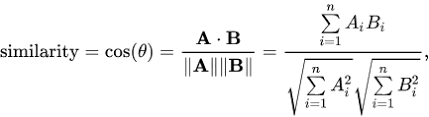

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [33]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [34]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movie_metadata.index, index=movie_metadata['Name']).drop_duplicates()
indices.head()

Name
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [35]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movie_metadata['Name'].iloc[movie_indices]

In [36]:
get_recommendations('The Dark Knight')

11984                                The Dark Knight Rises
1009                                        Batman Returns
10858                           Batman: Under the Red Hood
118                                         Batman Forever
13297    Batman Unmasked: The Psychology of the Dark Kn...
12896              Batman: The Dark Knight Returns, Part 2
19618    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
19893    Batman Beyond Darwyn Cooke's Batman 75th Anniv...
11892                                     Batman: Year One
12702              Batman: The Dark Knight Returns, Part 1
Name: Name, dtype: object

In [37]:
get_recommendations('The Avengers')

812      Monty Python and the Holy Grail
8996                 That Hamilton Woman
14850                     The Oblong Box
11318                La ragazza del lago
16530     The Ultimate Christmas Present
6126                         The Mangler
8732                L'Ivresse du pouvoir
1970                    An Ideal Husband
5933                             Ivanhoe
1366               A Man for All Seasons
Name: Name, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

**Credits, Genres and Keywords Based Recommender**

It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure.

In [38]:
# Parse the stringified features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature.

In [39]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [40]:
# Returns the list upto top 3 elements or entire list
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [41]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [42]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.



In [43]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [44]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [45]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [46]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [47]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [48]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as your second argument.

In [49]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65                Kicking and Screaming
119                       Belle de jour
4638           The Red Badge of Courage
1196                           Deceiver
3073                       Five Corners
3326      Il giardino dei Finzi Contini
1503    Something Wicked This Way Comes
1986                     Eyes Wide Shut
303                             Timecop
747                    Unhook the Stars
Name: Name, dtype: object

In [50]:
get_recommendations('The Godfather', cosine_sim2)

867                                      乱
2731            Per qualche dollaro in più
4638              The Red Badge of Courage
2649                             Gladiator
1525                                  Cujo
1018                                  Jaws
1170                        The Matchmaker
1209                             Anastasia
1394    Friday the 13th: The Final Chapter
1850                 House on Haunted Hill
Name: Name, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

# Collaborative Filtering

The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres. Also, the engine that we built is not personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically of two types:-

User based filtering- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

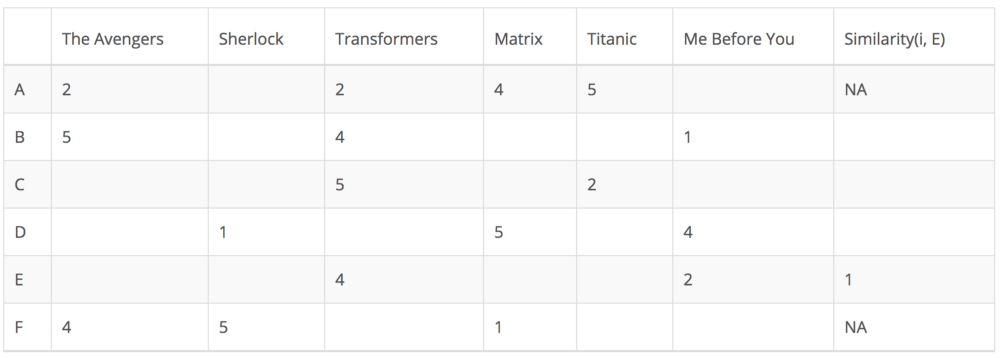



Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.

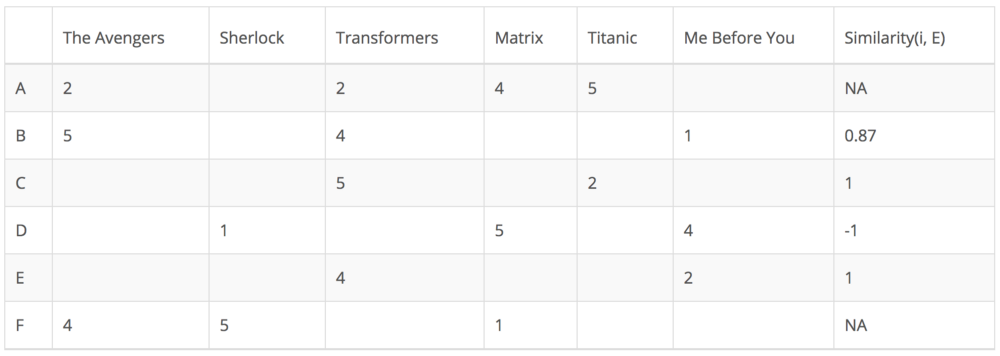



From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.

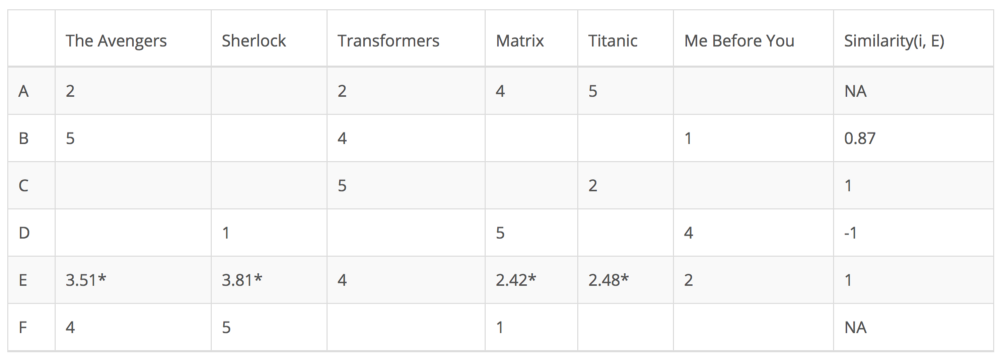



Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

Item Based Collaborative Filtering - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

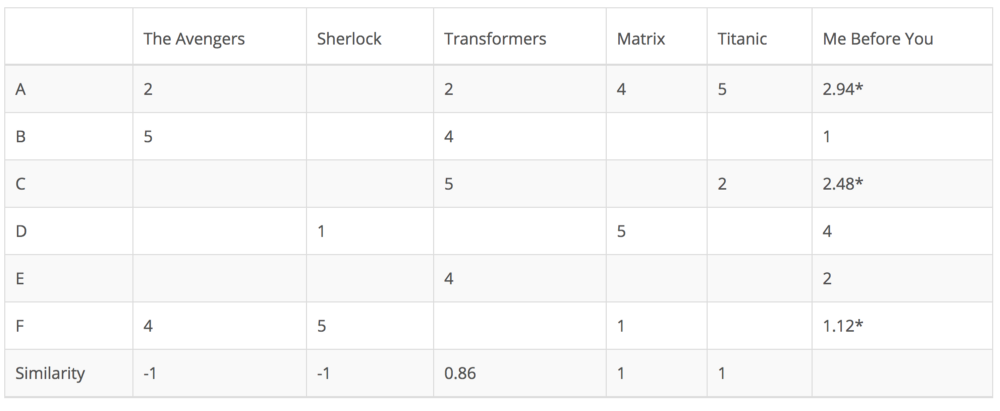



It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.

Single Value Decomposition
One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

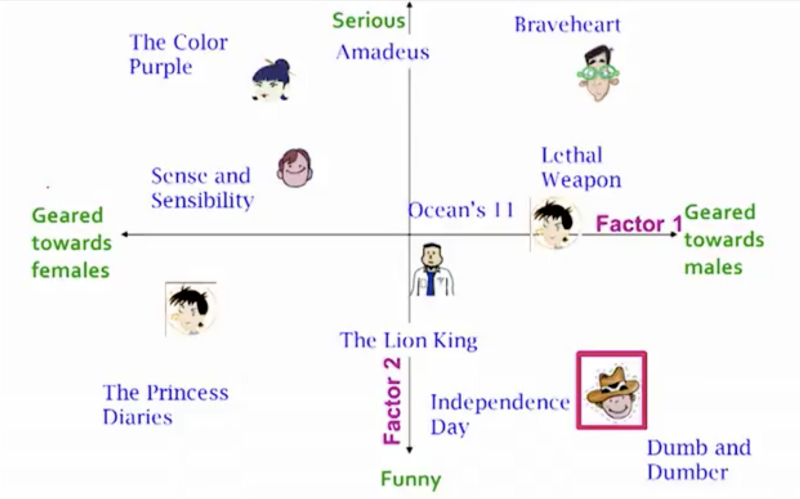

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [51]:
reader = Reader()
df.sample(5)

,User,Rating,Date,Movie
19416177,469308,4.0,2005-11-03,3689
10560528,2341483,3.0,2004-04-19,2072
9330780,952113,4.0,2005-08-21,1843
13752867,2102633,3.0,2003-04-22,2617
17515089,2332251,4.0,2005-05-02,3367


Note that in this dataset movies are rated on a scale of 5. Let us pick user with user Id 1488844 and check the ratings she/he has given.

In [52]:
df[df['User']=='1488844'].head()

,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
5157,1488844,4.0,2005-05-12,8
24369,1488844,2.0,2005-06-29,17
93296,1488844,3.0,2005-04-13,30
224788,1488844,3.0,2005-04-20,44


We're limiting the rows to get just top 100K rows for faster run time

In [53]:
df=df.head(100000)

In [54]:
reader = Reader()

data = Dataset.load_from_df(df[['User', 'Movie', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3)

{'test_rmse': array([1.04852505, 1.05276404, 1.05523185]),
 'test_mae': array([0.82905102, 0.83164266, 0.84604095]),
 'fit_time': (7.465402126312256, 7.441678285598755, 7.4772727489471436),
 'test_time': (0.45570874214172363, 0.4691181182861328, 0.46152710914611816)}

In [55]:
df_1488844 = df[(df['User'] == '1488844') & (df['Rating'] ==5)]
df_1488844 = df_1488844.set_index('Movie')
df_1488844 = df_1488844.join(movie_titles)['Name']
print(df_1488844)

Series([], Name: Name, dtype: object)


In [56]:
print((df[(df['User'] == '1488844') & (df['Rating'] == 4)]))

         User  Rating        Date  Movie
5157  1488844     4.0  2005-05-12      8


In [57]:
user_1488844 = movie_titles.copy()
user_1488844 = user_1488844.reset_index()
#user_1488844 = user_1488844[~user_1488844['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data=Dataset.load_from_df(df[['User', 'Movie', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_1488844['Estimate_Score'] = user_1488844['Movie'].apply(lambda x: svd.predict(1488844, x).est)

user_1488844 = user_1488844.drop('Movie', axis = 1)

user_1488844 = user_1488844.sort_values('Estimate_Score', ascending=False)
print(user_1488844.head(10))

      Year                                               Name  Estimate_Score
12  2003.0  Lord of the Rings: The Return of the King: Ext...        4.510169
24  1997.0      Inspector Morse 31: Death Is Now My Neighbour        4.000047
4   2004.0                           The Rise and Fall of ECW        3.948608
27  2002.0                                    Lilo and Stitch        3.850777
0   2003.0                                    Dinosaur Planet        3.801522
17  1994.0                                   Immortal Beloved        3.752002
2   1997.0                                          Character        3.706873
28  2001.0                                            Boycott        3.690554
29  2003.0                             Something's Gotta Give        3.673634
1   2004.0                         Isle of Man TT 2004 Review        3.669656


We created recommenders using demographic , content- based and collaborative filtering. While demographic filtering is very elemantary and cannot be used practically, Hybrid Systems can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary. This model was very baseline and only provides a fundamental framework to start with.

In [58]:
#userid and movie based rocommender
#Input: User ID and the Title of a Movie
#Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [59]:
##movie_meta=md

In [60]:
#movie_meta = movie_meta.drop([19730, 29503, 35587])
movie_meta['id'] = movie_meta['id'].astype('int')
smovie_meta = movie_meta[movie_meta['id'].isin(links_small)]
smovie_meta.shape

(463, 25)

In [61]:
movie_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 9 to 44842
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  659 non-null    object 
 1   belongs_to_collection  659 non-null    object 
 2   budget                 659 non-null    object 
 3   genres                 659 non-null    object 
 4   homepage               659 non-null    object 
 5   id                     659 non-null    int64  
 6   imdb_id                659 non-null    object 
 7   original_language      659 non-null    object 
 8   original_title         659 non-null    object 
 9   overview               659 non-null    object 
 10  popularity             659 non-null    object 
 11  poster_path            659 non-null    object 
 12  production_companies   659 non-null    object 
 13  production_countries   659 non-null    object 
 14  release_date           659 non-null    object 
 15  reve

In [62]:
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movie_meta['id'] = movie_meta['id'].astype('int')
movie_meta = movie_meta.merge(credits, on='id')
movie_meta = movie_meta.merge(keywords, on='id')
smovie_meta = movie_meta[movie_meta['id'].isin(links_small)]
smovie_meta.shape

smovie_meta['cast'] = smovie_meta['cast'].apply(literal_eval)
smovie_meta['crew'] = smovie_meta['crew'].apply(literal_eval)
smovie_meta['keywords'] = smovie_meta['keywords'].apply(literal_eval)
smovie_meta['cast_size'] = smovie_meta['cast'].apply(lambda x: len(x))
smovie_meta['crew_size'] = smovie_meta['crew'].apply(lambda x: len(x))
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
smovie_meta['director'] = smovie_meta['crew'].apply(get_director)
smovie_meta['cast'] = smovie_meta['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smovie_meta['cast'] = smovie_meta['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smovie_meta['keywords'] = smovie_meta['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smovie_meta['cast'] = smovie_meta['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smovie_meta['director'] = smovie_meta['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smovie_meta['director'] = smovie_meta['director'].apply(lambda x: [x,x, x])
s = smovie_meta.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]
s = s[s > 1]
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words
smovie_meta['keywords'] = smovie_meta['keywords'].apply(filter_keywords)
smovie_meta['keywords'] = smovie_meta['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smovie_meta['keywords'] = smovie_meta['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smovie_meta['soup'] = smovie_meta['keywords'] + smovie_meta['cast'] + smovie_meta['director'] + smovie_meta['genres']
smovie_meta['soup'] = smovie_meta['soup'].apply(lambda x: ' '.join(x))
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smovie_meta['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smovie_meta = smovie_meta.reset_index()
titles = smovie_meta['title']
indices = pd.Series(smovie_meta.index, index=smovie_meta['title'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [63]:
#smovie_meta = smovie_meta.reset_index()
#indices = pd.Series(smovie_meta.index, index=smovie_meta['title'])

In [64]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [65]:
id_map = pd.read_csv('../input/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smovie_meta[['title', 'id']], on='id').set_index('title')
id_map.head()

,movieId,id
title,,
GoldenEye,10,710.0
Friday,69,10634.0
From Dusk Till Dawn,70,755.0
Blue in the Face,156,5894.0
Mighty Morphin Power Rangers: The Movie,181,9070.0


In [66]:
id_map.shape

(471, 2)

In [67]:
indices_map = id_map.set_index('id')
indices_map

,movieId
id,
710.0,10
10634.0,69
755.0,70
5894.0,156
9070.0,181
...,...
43074.0,160080
324668.0,160438
316727.0,160565


In [68]:
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
#data.split(n_folds=5)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)
trainset = data.build_full_trainset()
svd.fit(trainset)

In [69]:
def hybrid(userId, title):
    idx = indices[title]
    tmovie_metabId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:5]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smovie_meta.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    #movies['est'] = movies['id'].apply(lambda x: svd.predict(1, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [70]:
hybrid(1, 'The Terminator')

,title,vote_count,vote_average,year,id,est
171,District B13,572.0,6.5,2004,10045,2.738600
275,Avatar,12114.0,7.2,2009,19995,2.736773
260,Terminator Salvation,2496.0,5.9,2009,534,2.581748
432,Terminator Genisys,3677.0,5.8,2015,87101,2.342685


In [71]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
31,The Terminator,4208.0,7.4,1984,218,3.190716
413,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.696651
391,Justice League: The Flashpoint Paradox,458.0,7.3,2013,183011,2.540160
385,Man of Steel,6462.0,6.5,2013,49521,2.508461


References :

https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75